






## 1.常数

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.colors as mcolors
from scipy.integrate import quad 
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded  ##用于求解线性方程组
from scipy.optimize import fsolve
import scipy.sparse
import scipy.sparse.linalg
from numpy import linspace, zeros, random, array
import time, sys
from mpl_toolkits.mplot3d import Axes3D
import scipy.interpolate
from matplotlib.colors import LogNorm
from itertools import cycle
from matplotlib.colors import Normalize
# constants  unit cgs
c = 29979245800.0 # speed of light
M_sun = 1.9891e33 # mass of sun
R_sun = 6.961e10 ## radius of sun
a_rad =7.56566*10**(-15) # radiation constant
pi = np.pi
sigma_SB=5.67032*10**(-5) # S-B constant
sigma_T=6.652448*10**(-25.0) # Thomson scattering cross
m_p=1.6726485*10**(-24.0) # mass of proton
m_e=9.109534*10**(-28.0) # mass of electron
q_e = 4.803242*10**(-10) #charge of electron
eV =1.6*10**(-12) ## eV in unit of erg  
km=10**5
day=3600*24.0
pc=3.08567756*10**(18.0)
Mpc=10**(6)*pc
hp=6.626176*10**(-27.0) #Planck constant
kb=1.380662*10**(-16.0) # Bolztmann constant
uJy=10**(-29.0)
mJy=10**(-26.0)
Jy=10**(-23.0)
yr=365*24*3600.0
GHz =1.0e9
H0 = 70.0*km/Mpc
nm = 1e-7
Omega_m = 0.30
Omega_L = 0.70




lambda_u = 354.3*nm ## u-band wavelength
lambda_g = 477.0*nm ## g-band wavelength
lambda_r = 623.1*nm ## r-band wavelength
lambda_i = 762.5*nm ## i-band wavelength
lambda_z = 909.7*nm ## z-band wavelength

nu_u = c/lambda_u ## frequency of u-band
nu_r = c/lambda_r ## frequency of r-band
nu_g = c/lambda_g ## frequency of g-band
nu_i = c/lambda_i ## frequency of i-band
nu_z = c/lambda_z ## frequency of z-band



lambda_B = 440*nm 
lambda_g = 470*nm 
lambda_V = 545*nm 
lambda_R = 640*nm 
lambda_i = 790*nm
nu_g = c/lambda_g 
nu_R= c/lambda_R 
nu_FUV = 2e15 
nu_V =c /lambda_V
nu_i = c/lambda_i
nu_B = c/lambda_B


tau_Ni =8.8*day
tau_Co = 111.3*day
eNi = 3.9e10 ## specific heating rate of Ni
eCo = 6.8e9 ## specific heating rate of Co
eCo_ratio = eCo /(eNi - eCo) # Co 沉积率比例

# =========================
# 1. 字体与渲染设置（避免LaTeX依赖）
# =========================
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "DejaVu Serif"],  # 回退字体
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 10,
    "axes.titlesize": 18
})

In [ ]:


class SupernovaLightCurve:
    """
    A simple illustrative numerical model for SNe IIP light curves.
    """

    def __init__(self):
        # Fundamental constants
        self.pi = np.pi
        self.c = 3.0e10                    # Speed of light (cm/s)
        self.sigma_SB = 5.670374419e-5     # Stefan-Boltzmann constant (erg cm^-2 s^-1 K^-4)
        self.a_rad = 7.5646e-15            # Radiation constant (erg cm^-3 K^-4)
        self.kb = 1.380649e-16             # Boltzmann constant (erg/K)
        self.hp = 6.62607015e-27           # Planck constant (erg s)
        self.pc = 3.086e18                 # 1 parsec (cm)
        self.day = 86400.0                 # number of seconds in one day

        # Example Ni/Co decay energy deposition rates
        self.eNi = 3.9e10  # erg/s/g (Nickel)
        self.eCo = 6.8e9   # erg/s/g (Cobalt)
        # Example decay timescales
        self.tau_Ni = 8.8 * self.day
        self.tau_Co = 111.4 * self.day

    def calculate_light_curve(self,
                              nu_obs=nu_R,
                              M_ej =  5.0*M_sun,
                              E_K =1.0e51,
                              E_Th_in =10e49, 
                              M_Ni = 0.2*M_sun,
                              kappa0=0.2,
                              R_max_in=100*R_sun,
                              x_max=1.0e4,
                              x_s=0.2,
                              Nx=100,
                              Ny=2000,
                              eta_ej_func=None):
        """
        Calculate the supernova light curve using a simplified PDE model.

        Parameters
        ----------
        nu_obs : float
            Observed frequency (Hz).
        M_ej : float
            Total ejecta mass (g).
        E_K : float
            Total kinetic energy (erg).
        E_Th_in : float
            Initial thermal energy (erg).
        M_Ni : float
            Nickel mass (g).
        kappa0 : float
            Mean opacity (cm^2 g^-1).
        R_max_in : float
            Initial outer radius (cm).
        x_max : float
            Maximum dimensionless radius.
        x_s : float
            Fraction of x_max within which nickel is distributed (0 <= x <= x_s*x_max).
        Nx : int
            Number of radial grid points.
        Ny : int
            Number of temporal grid points.
        eta_ej_func : callable, optional
            A custom radial density profile function, shape: eta_ej_func(x).
            If None, a simple linear-decreasing profile is used.

        Returns
        -------
        t_days : ndarray
            Time array in days, shape = (Ny,).
        L_bol_values : ndarray
            Bolometric luminosity as a function of time, shape = (Ny,).
        L_heat_values : ndarray
            Radioactive heating rate from Ni/Co decay, shape = (Ny,).
        x_vals_new : ndarray
            Dimensionless radial grid, x_vals / x_max, shape = (Nx+1,).
        e_values : ndarray
            Dimensionless internal energy distribution, shape = (Nx+1, Ny).
        T_values : ndarray
            Temperature distribution (K), shape = (Nx+1, Ny).
        T_eff_values : ndarray
            Photospheric temperature (K) as a function of time, shape = (Ny,).
        M_ab_values : ndarray
            Absolute magnitude (approximate) as a function of time, shape = (Ny,).
        """

        pi = self.pi
        day = self.day
        c = self.c
        a_rad = self.a_rad
        sigma_SB = self.sigma_SB

        # 1) If eta_ej_func is not provided, use a simple linear profile
        if eta_ej_func is None:
            def eta_ej_func(x):
                return 1.0 - 0.01 * x / x_max

        # 2) Dimensionless radius limits
        x_min = 1.0
        x_heat = x_s * x_max  # nickel distribution cutoff

        # 3) Compute integrals for total mass and kinetic energy factors
        def Int_I_M(x):
            return x*x * eta_ej_func(x)

        def Int_I_K(x):
            return x**4 * eta_ej_func(x)

        I_M = quad(Int_I_M, x_min, x_max, epsabs=1e-5, limit=100)[0]
        I_K = quad(Int_I_K, x_min, x_max, epsabs=1e-5, limit=100)[0]

        # 4) Characteristic scales
        #    - R_min_in: radius corresponding to x=1
        #    - rho_in: average density scale at the inner boundary
        R_min_in = R_max_in / x_max
        rho_in = M_ej / (4.0 * pi * I_M * R_min_in**3)

        #    - v_min: velocity at x=1
        #    - t_ex: expansion timescale
        v_min = np.sqrt(2.0 * I_M * E_K / (I_K * M_ej))
        t_ex = R_min_in / v_min

        #    - t_diff: photon diffusion timescale
        t_diff = 3.0 * kappa0 * rho_in * R_min_in**2 / c

        #    - dimensionless reference for internal energy
        #      e_heat0: (Ni - Co) energy deposition rate per unit mass
        e_heat0 = (self.eNi - self.eCo)
        eCo_ratio = self.eCo / (self.eNi - self.eCo)
        u0 = rho_in * e_heat0 * t_diff  # scale factor to convert dimensionless e-values to physical energy density

        #    - L0: scale factor for luminosity (used in a rough estimate at the outer boundary)
        L0 = (4.0 * pi * R_min_in * c * u0) / (3.0 * kappa0 * rho_in)
        tau_in = kappa0 * rho_in * R_min_in

        # 5) Initial internal energy distribution e0(x)
        def e_initial(x):
            """
            Dimensionless initial internal energy distribution, ~ 1/x.
            The coefficient below can be adjusted for specific physical scenarios.
            """
            e0 = E_Th_in / (2.0 * pi * u0 * x_max**2 * R_min_in**3)
            return e0 / x

        # 6) Auxiliary functions
        def f_R(y):
            """
            Dimensionless radius ratio: R(t) / R(0) = 1 + (t/t_ex).
            Here t = y * t_diff, so f_R(y) = 1 + (y*t_diff / t_ex).
            """
            return 1.0 + (y * t_diff / t_ex)

        def R_max_func(y):
            """
            Outer radius as a function of dimensionless time y.
            Physical time t = y * t_diff.
            R(t) = R_min_in * x_max + v_min * x_max * t.
            """
            t_phys = y * t_diff
            return R_min_in * x_max + v_min * x_max * t_phys

        def f_heat(y):
            """
            Radioactive heating factor (Ni and Co), dimensionless time y => t = y*t_diff.
            Ni -> exp(-t/tau_Ni), Co -> exp(-t/tau_Co).
            """
            t_phys = y * t_diff
            return np.exp(-t_phys / self.tau_Ni) + eCo_ratio * np.exp(-t_phys / self.tau_Co)

        # 7) Nickel distribution (uniform in x < x_heat)
        denom = quad(Int_I_M, x_min, x_heat, epsabs=1e-5, limit=100)[0]
        xi0 = (I_M * M_Ni / M_ej) / denom

        def xi_heat_func(x_array):
            """
            Returns an array of nickel fraction xi for each x in x_array.
            Nickel is uniformly distributed up to x_heat.
            """
            out = np.zeros_like(x_array)
            mask = (x_array >= x_min) & (x_array <= x_heat)
            out[mask] = xi0
            return out

        # 8) Discretization in space and time
        x_vals = np.linspace(x_min, x_max, Nx+1)
        dx = (x_max - x_min) / Nx

        t_max = 300 * day  # e.g., compute up to 300 days
        y_max = t_max / t_diff
        y_vals = np.linspace(0.0, y_max, Ny+1)
        dy = y_vals[1] - y_vals[0]

        # 9) Allocate solution arrays
        e_values = np.zeros((Nx+1, Ny+1))  # dimensionless internal energy
        T_values = np.zeros((Nx+1, Ny+1))  # temperature
        L_bol_values = np.zeros(Ny+1)      # total/bolometric luminosity
        L_heat_values = np.zeros(Ny+1)     # Ni/Co decay heating rate
        T_eff_values = np.zeros(Ny+1)      # photospheric temperature
        M_ab_values = np.zeros(Ny+1)       # absolute magnitude

        # Initial condition
        e_values[:, 0] = e_initial(x_vals)

        # 10) Prepare arrays for tridiagonal solver
        diagonal = np.zeros(Nx+1)
        lower = np.zeros(Nx)
        upper = np.zeros(Nx)
        b_vec = np.zeros(Nx+1)

        # Pre-calculate eta_ej and xi_heat at each spatial point
        eta_vals = eta_ej_func(x_vals)
        xi_vals = xi_heat_func(x_vals)

        # Helper for the outer boundary condition
        def f_ob(y_):
            """
            Outer boundary factor f_ob(y).
            Used for boundary condition at x = x_max (i = Nx).
            """
            return -(2.0 / (3.0 * tau_in * eta_ej_func(x_max))) * (f_R(y_))**2

        # 11) Time stepping loop
        for n in range(Ny):
            y_now = y_vals[n]
            y_next = y_vals[n+1]

            # Next-time step expansions
            fR_next = f_R(y_next)
            # D_eff at y_next
            D_next = (x_vals**2 / eta_vals) * fR_next

            # Current-time expansions
            fR_now = f_R(y_now)
            D_now = (x_vals**2 / eta_vals) * fR_now

            # S(x, y): the source (Ni/Co) at current and next times
            S_now = fR_now * eta_vals * xi_vals * f_heat(y_now)
            S_next = fR_next * eta_vals * xi_vals * f_heat(y_next)

            # Set up the tridiagonal matrix for Crank-Nicolson
            x_inner = x_vals[1:-1]
            mu_val = 0.25 * dy / (x_inner * dx)**2

            diag_mid = mu_val * (D_next[2:] + 2.0 * D_next[1:-1] + D_next[:-2])
            diagonal[1:-1] = 1.0 + diag_mid

            lower[:-1] = -mu_val * (D_next[1:-1] + D_next[:-2])
            upper[1:] = -mu_val * (D_next[2:] + D_next[1:-1])

            # Boundary conditions
            # Left (i=0)
            diagonal[0] = -1.0
            upper[0] = 1.0
            # Right (i=Nx)
            diagonal[Nx] = dx - f_ob(y_next)
            lower[-1] = f_ob(y_next)

            # Assemble the sparse matrix
            A = scipy.sparse.diags(
                [diagonal, lower, upper],
                offsets=[0, -1, 1],
                shape=(Nx+1, Nx+1),
                format='csr'
            )

            # Right-hand side b
            e_now = e_values[:, n]
            b_vec[1:-1] = (
                e_now[1:-1]
                + 0.5 * dy * (S_now[1:-1] + S_next[1:-1])
                + mu_val * (
                    (D_now[2:] + D_now[1:-1]) * (e_now[2:] - e_now[1:-1])
                    - (D_now[1:-1] + D_now[:-2]) * (e_now[1:-1] - e_now[:-2])
                )
            )
            b_vec[0] = 0.0
            b_vec[Nx] = 0.0

            # Solve the linear system for e[:, n+1]
            e_values[:, n+1] = scipy.sparse.linalg.spsolve(A, b_vec)

            # 12) Compute temperature, luminosity, etc. at time step n+1
            e_next = e_values[:, n+1]
            T_values[:, n+1] = (1.0 / fR_next) * ((e_next * u0 / a_rad))**0.25

            # Bolometric luminosity (rough estimate)
            # L_bol ~ L0 * ( x_max^2 / eta_ej(x_max) ) * [ e(Nx-1) - e(Nx) ] / dx
            L_bol_values[n+1] = L0 * (x_max**2 / eta_ej_func(x_max)) \
                                * (e_next[Nx-1] - e_next[Nx]) / dx

            # Photospheric temperature
            R_outer = R_max_func(y_next)
            T_eff_values[n+1] = (L_bol_values[n+1] / (4.0 * pi * R_outer**2 * sigma_SB))**0.25

            # Approximate absolute magnitude in a single band
            T_floor = 2000.0
            T_for_calc = max(T_eff_values[n+1], T_floor)
            x_obs = self.hp * nu_obs / (self.kb * T_for_calc)
            B_nu = 2.0 * self.hp * nu_obs**3 / self.c**2 / (np.exp(x_obs) - 1.0)
            L_nu = 4.0 * pi * pi * R_outer**2 * B_nu
            F_nu = L_nu / (4.0 * pi * (10.0 * self.pc)**2)
            # Magnitude
            M_ab_values[n+1] = -2.5 * np.log10(F_nu) - 48.6

            # Ni/Co heating rate (just for reference)
            L_heat_values[n+1] = M_Ni * (self.eNi - self.eCo) * f_heat(y_next)

        # 13) Convert time array to days, and remove the step 0 if desired
        t_days = y_vals * (t_diff / day)

        # Strip the t=0 data if desired, or keep them for completeness
        t_days = t_days[1:]
        L_bol_values = L_bol_values[1:]
        L_heat_values = L_heat_values[1:]
        T_eff_values = T_eff_values[1:]
        M_ab_values = M_ab_values[1:]
        T_values = T_values[:, 1:]

        # Dimensionless radial grid
        x_new = x_vals / x_max

        return t_days,L_bol_values,L_heat_values,x_new, T_values, T_eff_values, M_ab_values
     
    def Arnett_light_curve(self,
                              nu_obs= nu_R,
                              M_ej= 5.0*M_sun,
                              E_K= 1.0e51,
                              E_Th_in= 1.0e49,
                              M_Ni= 0.5*M_sun,
                              kappa0=0.2,
                              R_max_in=100*R_sun,
                              ):
        """
        计算超新星光变曲线。

        参数：
        -------
        nu_obs   : float，观测频率（默认取 R 波段的频率）
        M_ej     : float，喷发物总质量，默认 5.0 个太阳质量
        E_K      : float，总动能 (erg)，默认 1e51 erg
        E_Th_in  : float，初始热能 (erg)，默认 1e49 erg
        M_Ni     : float，镍质量，默认 0.5 个太阳质量
        kappa0   : float，平均不透明度 (cm^2 g^-1)，默认 0.2
        R_max_in : float，初始最外层半径 (cm)，默认 1e9
        """
        Nt = 500 ## number of time steps
        Nx = 100 ## 
        t_vals = np.linspace(0.01,300,Nt)*day
        x_vals = np.linspace(0.001,1,Nx)
        v_ej = (2.0 * E_K / M_ej)**0.5 ## typical ejecta velocity
        t_diff = (2.0 * kappa0*M_ej/(13.8*v_ej*c))**(0.5) ## Arnett diffusion time scale
        tau_diff= (2.0*kappa0*M_ej/(13.8*v_ej*v_ej))**(0.5) ## Arnett diffusion time scale
        y_vals = t_vals/t_diff ## dimensionless time
        y_tau =tau_diff/t_diff ##无量纲变成透明的时间
        L_bol_Arnett = np.zeros(Nt)
        T_vals_Arnett = np.zeros((Nx,Nt))
        def f_heat(y): ##归一化的镍的加热率
            t = y*t_diff
            return np.exp(-t / tau_Ni) + eCo_ratio * np.exp(- t /tau_Co) 
        def Int_I_LC(x):
            return x*np.exp(x**2.0) *f_heat(x) 
        for n, y in enumerate(y_vals):
            if y <2.0*y_tau:
                I_LC= quad(Int_I_LC, 0,y, epsabs=1e-2, limit=100)[0]
                L_bol_Arnett[n] = 2.0*M_Ni*(eNi - eCo )*np.exp(-y**2.0) *I_LC
            else:
                L_bol_Arnett[n] = M_Ni*(eNi - eCo )*f_heat(y)
        R_ph = R_max_in + v_ej*t_vals
        T_eff_Arnett = (L_bol_Arnett/(4*pi*R_ph**2*sigma_SB))**0.25
        def f_T_Arnett(x):
            return (np.sin(0.99*pi*x)/(x*np.sin(0.99*pi)))**(0.25)
        Phi_T_Arnett = f_T_Arnett(x_vals) ## dimensionless temperature profile
        for n, y in enumerate(y_vals):  
            T_vals_Arnett[:,n] = T_eff_Arnett[n]*Phi_T_Arnett ## temperature profile
        t_days_Arnett = t_vals/day
        return t_days_Arnett,x_vals, L_bol_Arnett,T_eff_Arnett,T_vals_Arnett
            
    def Onezone_light_curve(self,
                              nu_obs= nu_R,
                              M_ej= 5.0*M_sun,
                              E_K= 1.0e51,
                              E_Th_in= 1.0e49,
                              M_Ni= 0.5*M_sun,
                              kappa0=0.2,
                              R_max_in=100*R_sun,
                              ):
        Nt = 500 ## number of time steps
        Nx = 100 ## 
        t_vals = np.linspace(0.01,300,Nt)*day
        x_vals = np.linspace(0.0001,1,Nx)
        v_ej = (2.0 * E_K / M_ej)**0.5 ## typical ejecta velocity
        t_diff = (3.0 * kappa0*M_ej/(4.0*pi*v_ej*c))**(0.5) ## one-zone diffusion time scale
        tau_diff= (3.0*kappa0*M_ej/(4.0*pi*v_ej*v_ej))**(0.5) ## one-zone diffusion time scale
        y_vals = t_vals/t_diff ## dimensionless time
        y_tau =tau_diff/t_diff ##无量纲变成透明的时间
        L_bol_onezone = np.zeros(Nt)
        def f_heat(y): ##归一化的镍的加热率
            t = y*t_diff
            return np.exp(-t / tau_Ni) + eCo_ratio * np.exp(- t /tau_Co) 
        def Int_I_LC(x):
            return x*np.exp(x**2.0) *f_heat(x) 
        for n, y in enumerate(y_vals):
            if y <2.0*y_tau:
                I_LC= quad(Int_I_LC, 0,y, epsabs=1e-2, limit=100)[0]
                L_bol_onezone[n] = 2.0*M_Ni*(eNi - eCo )*np.exp(-y**2.0) *I_LC
            else:
                L_bol_onezone[n] = M_Ni*(eNi - eCo )*f_heat(y)
        R_ph = R_max_in + v_ej*t_vals
        T_eff_onezone = (L_bol_onezone/(4*pi*R_ph**2*sigma_SB))**0.25
        def f_T_onezone(x):
            return ((1.01-x)/0.01)**(0.25)
        Phi_T_onezone = f_T_onezone(x_vals)
        T_vals_onezone = np.zeros((Nx,Nt))
        for n, y in enumerate(y_vals):  
            T_vals_onezone[:,n] = T_eff_onezone[n]*Phi_T_onezone
        t_days_onezone = t_vals/day
        return t_days_onezone,x_vals, L_bol_onezone,T_eff_onezone,T_vals_onezone


In [30]:
sn = SupernovaLightCurve()
t_days,L_bol_values,L_heat_values,x_new,  T_values, T_eff_values, M_ab_values = sn.calculate_light_curve(M_Ni=0.2*M_sun)
t_days_Arnett,x_vals, L_bol_Arnett,T_eff_Arnett,T_vals_Arnett = sn.Arnett_light_curve(M_Ni=0.2*M_sun)
t_days_onezone,x_vals, L_bol_onezone,T_eff_onezone,T_vals_onezone = sn.Onezone_light_curve(M_Ni=0.2*M_sun)

In [32]:
T_u_peak=0.29/lambda_u
T_g_peak=0.29/lambda_g
T_r_peak=0.29/lambda_r
T_i_peak=0.29/lambda_i
T_z_peak=0.29/lambda_z

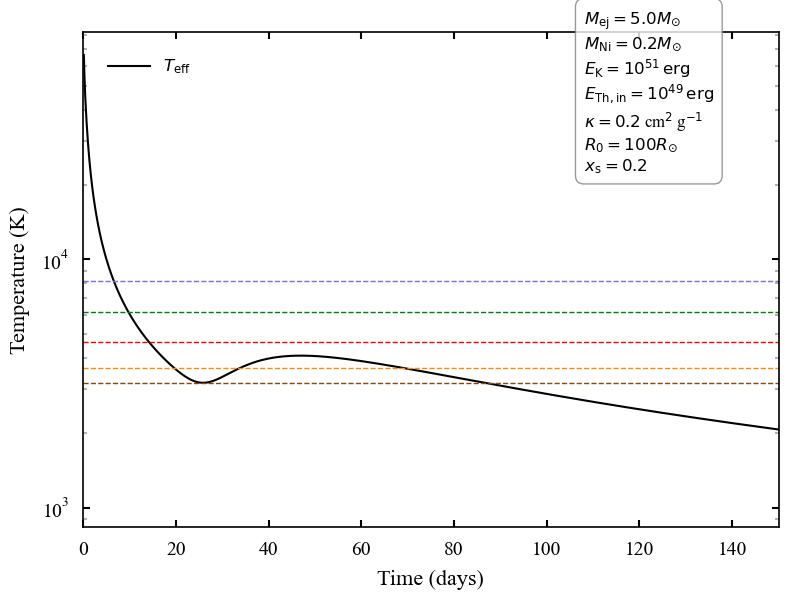

In [33]:

T_eff_values= sn.calculate_light_curve(nu_obs=nu_r,E_Th_in=10e49)[5]
plt.figure(figsize=(8, 6),dpi=100)
plt.plot(t_days,T_eff_values,'black', label=r'$T_{\rm{eff}}$')

plt.axhline(y=T_u_peak,  color='#7B68EE',linestyle='--', linewidth=1)
plt.axhline(y=T_g_peak,  color='green', linestyle='--', linewidth=1)
plt.axhline(y=T_r_peak,  color='red', linestyle='--', linewidth=1)
plt.axhline(y=T_i_peak,  color='#FF8C00', linestyle='--', linewidth=1)
plt.axhline(y=T_z_peak,  color='#8B4513', linestyle='--', linewidth=1)

plt.tick_params(
    axis='both', 
    which='both',
    direction='in',        # 刻度朝向图形内部
    top=True,               # 开启上侧刻度
    right=True,             # 开启右侧刻度
    labelsize=14,
    width=1.5,
    length=5,             # 主刻度长度
    pad=10                 # 标签与刻度间距
)
plt.tick_params(
    which='minor', 
    direction='in',         # 次刻度同样朝内
    length=3,               # 次刻度稍短
    color='0.7'             # 灰色次刻度
)
# 增强图例可读性
plt.legend(fontsize=12, 
           frameon=False,  # Remove the border
           loc='upper left',
           handlelength=2.5,
           borderpad=1.0,
           shadow=False)  # Remove the shadow


# 参数框设置
params_text = (
    r"$M_{\rm ej}=5.0M_{\odot}$" + "\n"
    + r"$M_{\rm Ni}=0.2M_{\odot}$" + "\n"
    + r"$E_{\rm K}=10^{51} \, \rm{erg}$" + "\n"
    + r"$E_{\rm Th,in}=10^{49} \, \rm{erg}$"  +"\n"
    + r"$\kappa=0.2$ cm$^{2}$ g$^{-1}$" + "\n"
    + r"$R_{\rm 0}=100R_{\odot}$" + "\n"
    + r"$x_{\rm s}=0.2$"
)
plt.annotate(params_text, 
            xy=(0.72, 0.72),  # 调整到右上方
            xycoords='axes fraction',
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

# 网格线优化（主次网格）
# plt.grid(True, which='major', ls='-', alpha=0.5, lw=1.2)
# plt.grid(True, which='minor', ls=':', alpha=0.3, lw=0.8)
plt.tight_layout()

# 保存图像，提升分辨率

plt.xlim(0, 150)
plt.xlabel('Time (days)', fontsize=16, labelpad=8)
plt.ylabel('Temperature (K)', fontsize=16, labelpad=8)
plt.yscale('log')
plt.savefig("T_eff.pdf",bbox_inches='tight',  dpi=1000)  # 高分辨率保存
plt.show()

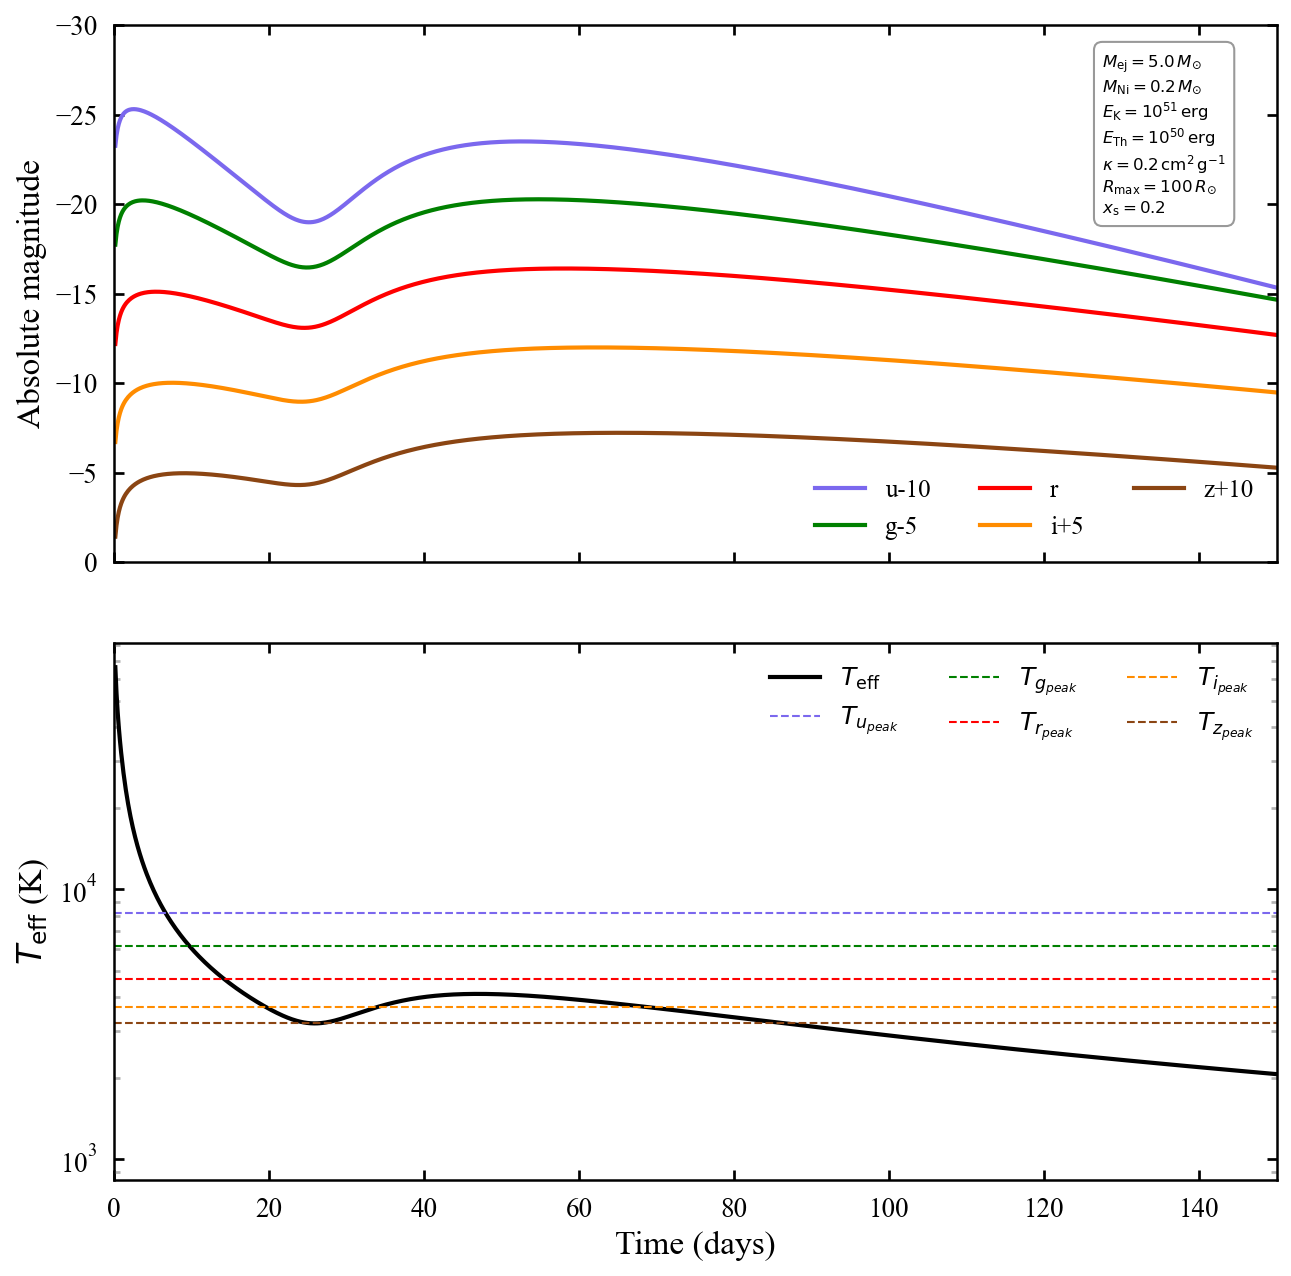

In [34]:
import matplotlib.pyplot as plt

# 准备光变和温度数据
m_u = sn.calculate_light_curve(nu_obs=nu_u, E_Th_in=1e50)[6] - 10
m_g = sn.calculate_light_curve(nu_obs=nu_g, E_Th_in=1e50)[6] - 5
m_r = sn.calculate_light_curve(nu_obs=nu_r, E_Th_in=1e50)[6]
m_i = sn.calculate_light_curve(nu_obs=nu_i, E_Th_in=1e50)[6] + 5
m_z = sn.calculate_light_curve(nu_obs=nu_z, E_Th_in=1e50)[6] + 10
T_eff = sn.calculate_light_curve(nu_obs=nu_r, E_Th_in=1e50)[5]

# 创建画布和子图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), dpi=150, sharex=True, gridspec_kw={'hspace': 0.15})

# === 上图：光变曲线 ===
ax1.plot(t_days, m_u, color='#7B68EE', linewidth=2, label='u-10')
ax1.plot(t_days, m_g, color='green', linewidth=2, label='g-5')
ax1.plot(t_days, m_r, color='red', linewidth=2, label='r')
ax1.plot(t_days, m_i, color='#FF8C00', linewidth=2, label='i+5')
ax1.plot(t_days, m_z, color='#8B4513', linewidth=2, label='z+10')
ax1.set_ylabel('Absolute magnitude', fontsize=16)
ax1.set_ylim(0, -30)
ax1.set_xlim(0, 150)
ax1.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=13, width=1.3, length=5, pad=8)
ax1.tick_params(which='minor', direction='in', length=3, color='0.7')
ax1.legend(fontsize=12, frameon=False, loc='lower right', ncol=3)

# 参数框
params_text = (
    r"$M_{\rm ej}=5.0\,M_{\odot}$" + "\n"
    + r"$M_{\rm Ni}=0.2\,M_{\odot}$" + "\n"
    + r"$E_{\rm K}=10^{51}\,{\rm erg}$" + "\n"
    + r"$E_{\rm Th}=10^{50}\,{\rm erg}$" + "\n"
    + r"$\kappa=0.2\,{\rm cm}^2\,{\rm g}^{-1}$" + "\n"
    + r"$R_{\rm max}=100\,R_{\odot}$" + "\n"
    + r"$x_{\rm s}=0.2$"
)
ax1.annotate(params_text, xy=(0.85, 0.65), xycoords='axes fraction',
             fontsize=8, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

# === 下图：温度演化 ===
ax2.plot(t_days, T_eff, color='black', label=r'$T_{\rm eff}$', linewidth=2)
ax2.axhline(y=T_u_peak, color='#7B68EE', linestyle='--', linewidth=1,label=r'$T_{u_{peak}}$')
ax2.axhline(y=T_g_peak, color='green', linestyle='--', linewidth=1, label=r'$T_{g_{peak}}$')
ax2.axhline(y=T_r_peak, color='red', linestyle='--', linewidth=1, label=r'$T_{r_{peak}}$')
ax2.axhline(y=T_i_peak, color='#FF8C00', linestyle='--', linewidth=1, label=r'$T_{i_{peak}}$')
ax2.axhline(y=T_z_peak, color='#8B4513', linestyle='--', linewidth=1, label=r'$T_{z_{peak}}$')

ax2.set_xlabel('Time (days)', fontsize=16)
ax2.set_ylabel(r'$T_{\rm{eff}}$ (K)', fontsize=16)
ax2.set_yscale('log')
ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=13, width=1.3, length=5, pad=8)
ax2.tick_params(which='minor', direction='in', length=3, color='0.7')
ax2.legend(fontsize=12, frameon=False, loc='upper right', ncol=3)

# 保存图像
plt.savefig("combined_mag_temp_vertical.pdf", bbox_inches='tight', dpi=1000)
plt.show()


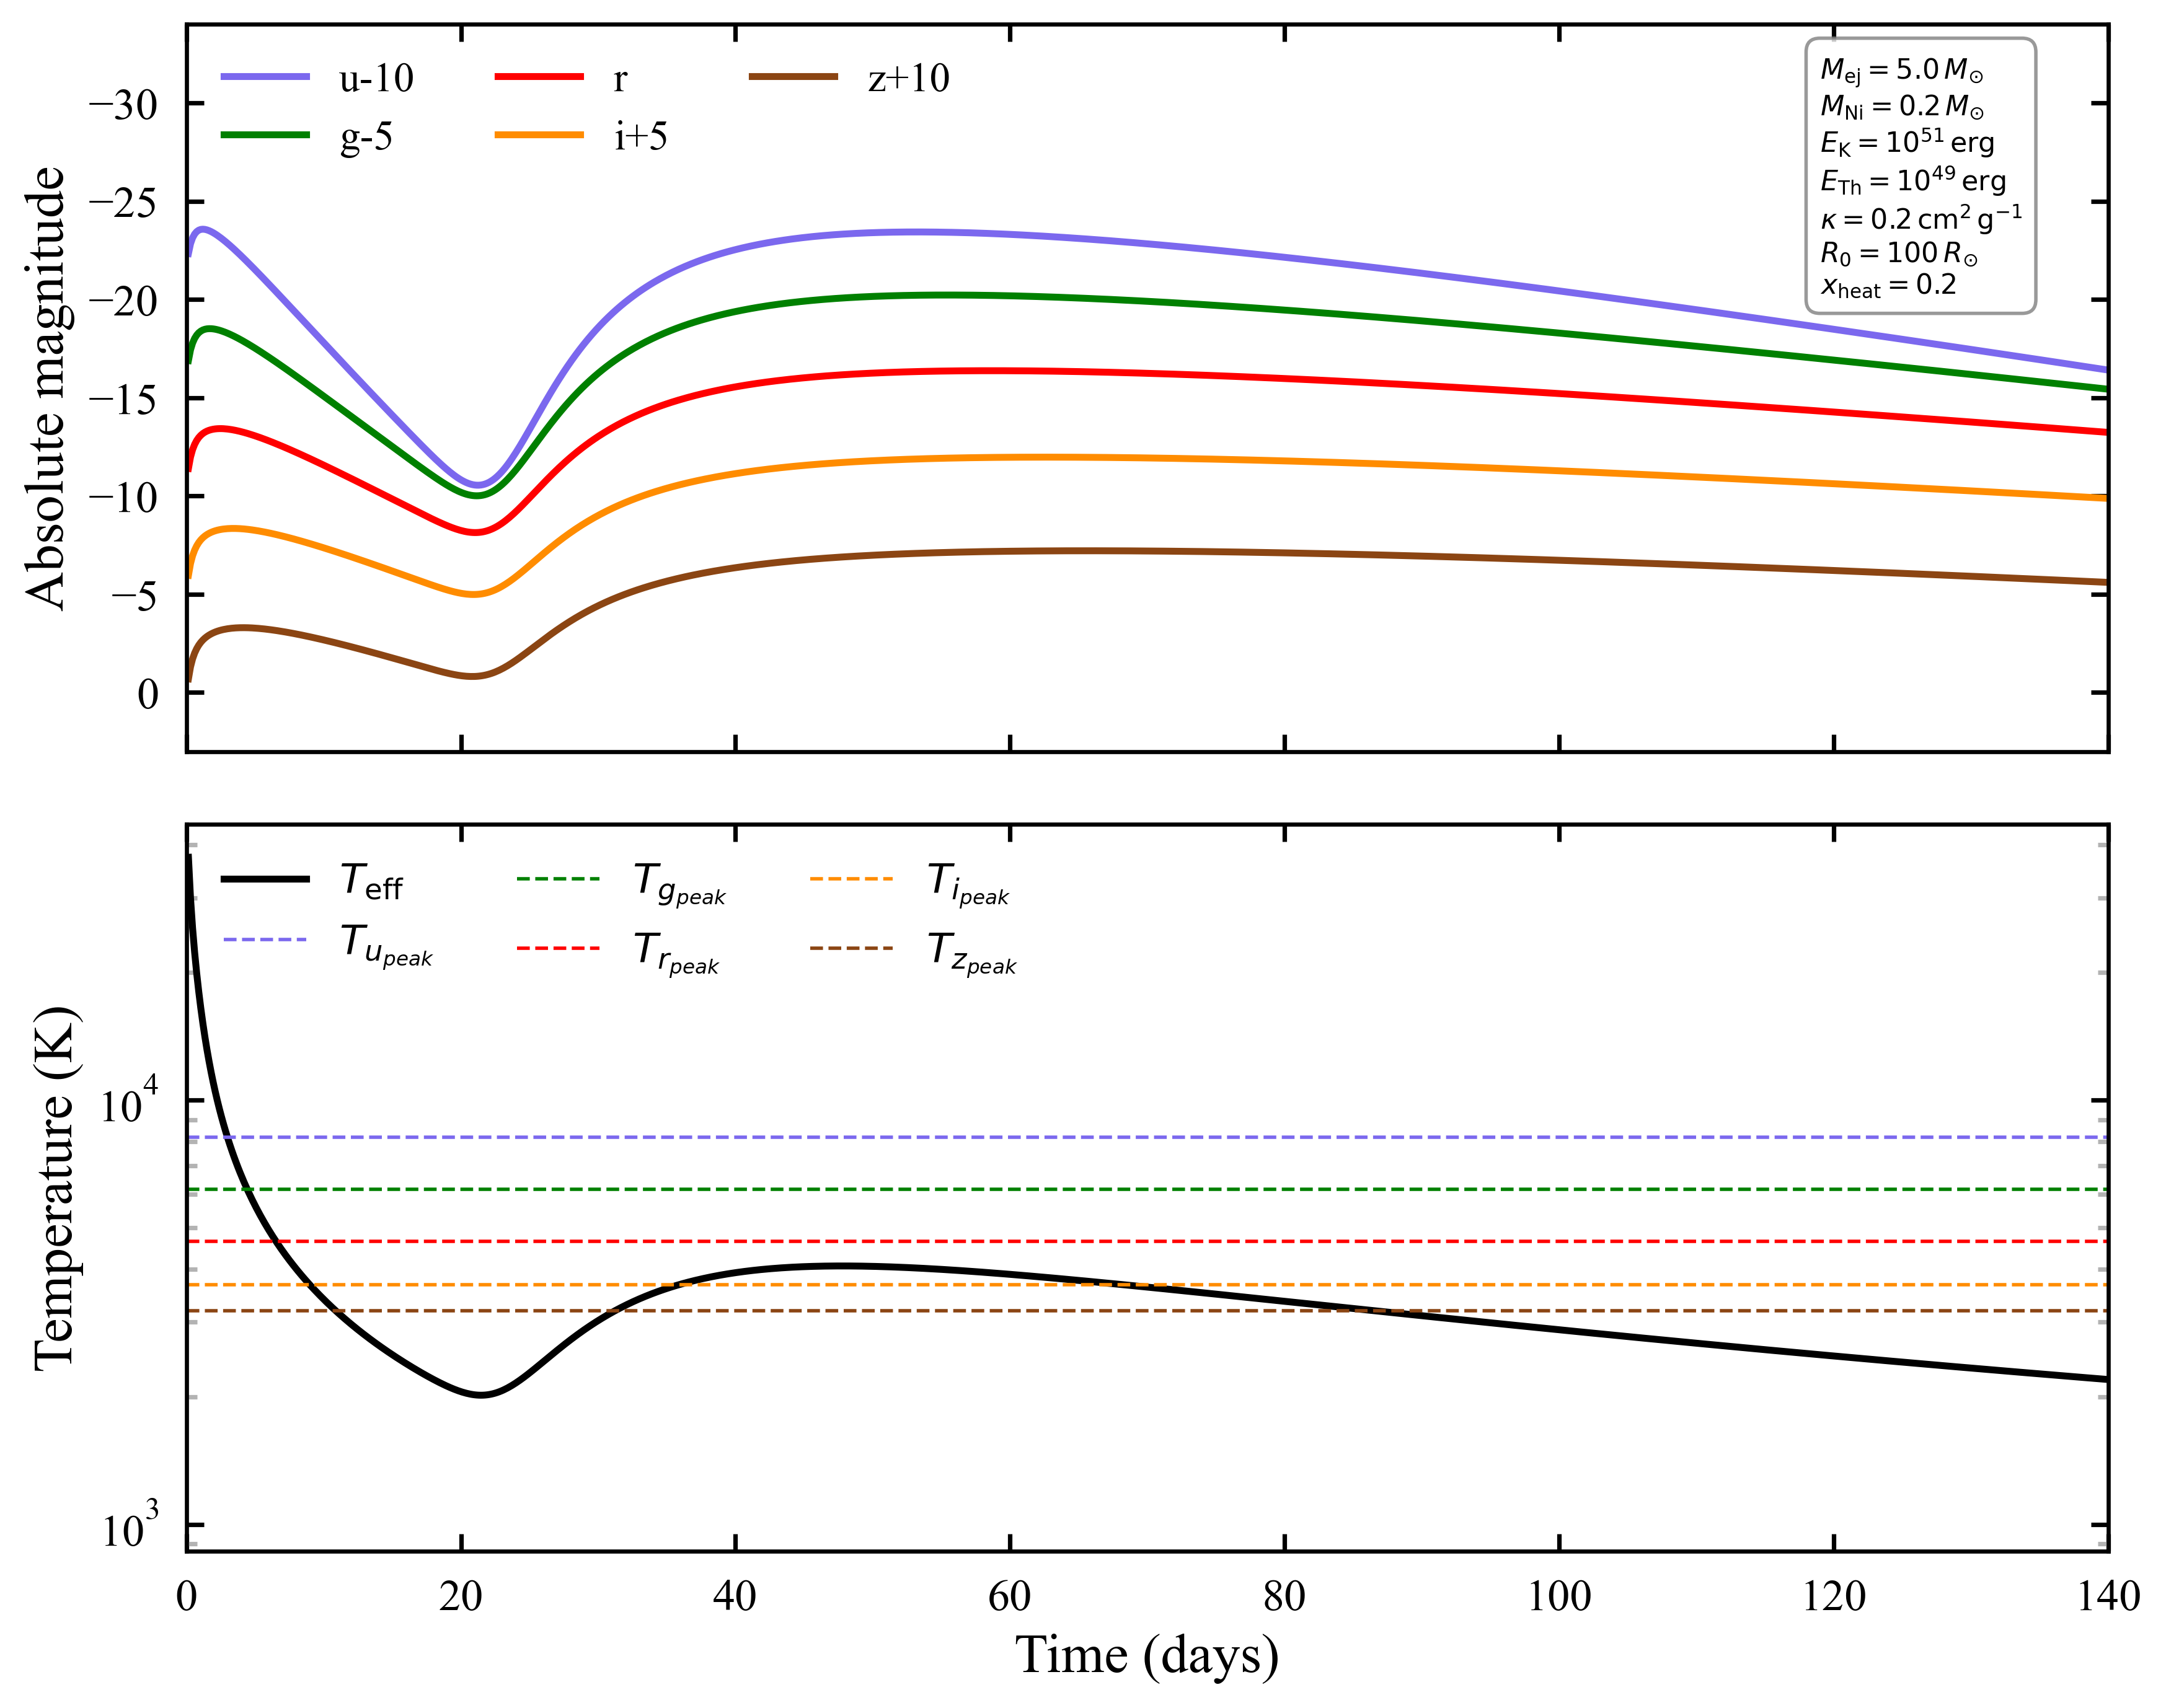

In [42]:

# 准备光变和温度数据
m_u = sn.calculate_light_curve(nu_obs=nu_u, E_Th_in=1e49)[6] - 10
m_g = sn.calculate_light_curve(nu_obs=nu_g, E_Th_in=1e49)[6] - 5
m_r = sn.calculate_light_curve(nu_obs=nu_r, E_Th_in=1e49)[6]
m_i = sn.calculate_light_curve(nu_obs=nu_i, E_Th_in=1e49)[6] + 5
m_z = sn.calculate_light_curve(nu_obs=nu_z, E_Th_in=1e49)[6] + 10
T_eff = sn.calculate_light_curve(nu_obs=nu_r, E_Th_in=1e49)[5]

# 创建画布和子图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), dpi=400,
                               sharex=True, gridspec_kw={'hspace': 0.1})

# === 上图：光变曲线 ===
ax1.plot(t_days, m_u, color='#7B68EE', linewidth=2, label='u-10')
ax1.plot(t_days, m_g, color='green', linewidth=2, label='g-5')
ax1.plot(t_days, m_r, color='red', linewidth=2, label='r')
ax1.plot(t_days, m_i, color='#FF8C00', linewidth=2, label='i+5')
ax1.plot(t_days, m_z, color='#8B4513', linewidth=2, label='z+10')
ax1.set_ylabel('Absolute magnitude', fontsize=16)
ax1.set_ylim(3, -34)
ax1.set_xlim(0, 140)
ax1.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=13, width=1.3, length=5, pad=8)
ax1.tick_params(which='minor', direction='in', length=3, color='0.7')
ax1.legend(fontsize=12, frameon=False, loc='upper left', ncol=3)

# 参数框
params_text = (
    r"$M_{\rm ej}=5.0\,M_{\odot}$" + "\n"
    + r"$M_{\rm Ni}=0.2\,M_{\odot}$" + "\n"
    + r"$E_{\rm K}=10^{51}\,{\rm erg}$" + "\n"
    + r"$E_{\rm Th}=10^{49}\,{\rm erg}$" + "\n"
    + r"$\kappa=0.2\,{\rm cm}^2\,{\rm g}^{-1}$" + "\n"
    + r"$R_{0}=100\,R_{\odot}$" + "\n"
    + r"$x_{\rm heat}=0.2$"
)
ax1.annotate(params_text, xy=(0.85, 0.63), xycoords='axes fraction',
             fontsize=8, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

# === 下图：温度演化 ===
ax2.plot(t_days, T_eff, color='black', label=r'$T_{\rm eff}$', linewidth=2)
ax2.axhline(y=T_u_peak, color='#7B68EE', linestyle='--', linewidth=1,label=r'$T_{u_{peak}}$')
ax2.axhline(y=T_g_peak, color='green', linestyle='--', linewidth=1, label=r'$T_{g_{peak}}$')
ax2.axhline(y=T_r_peak, color='red', linestyle='--', linewidth=1, label=r'$T_{r_{peak}}$')
ax2.axhline(y=T_i_peak, color='#FF8C00', linestyle='--', linewidth=1, label=r'$T_{i_{peak}}$')
ax2.axhline(y=T_z_peak, color='#8B4513', linestyle='--', linewidth=1, label=r'$T_{z_{peak}}$')

ax2.set_xlabel('Time (days)', fontsize=16)
ax2.set_ylabel('Temperature (K)', fontsize=16)
ax2.set_yscale('log')
ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=13, width=1.3, length=5, pad=8)
ax2.tick_params(which='minor', direction='in', length=3, color='0.7')
ax2.legend(fontsize=12, frameon=False, loc='upper left', ncol=3)

# 保存图像
plt.savefig("combined_mag_temp_vertical.pdf", bbox_inches='tight', dpi=1000)
plt.show()